## **Vision Transformer (ViT)**

The Vision Transformer (ViT) is a groundbreaking neural network architecture designed for image classification tasks. Unlike traditional Convolutional Neural Networks (CNNs), ViT leverages the transformer architecture originally developed for natural language processing. The fundamental idea behind ViT is to treat an image as a sequence of patches and process it using transformer-based mechanisms.

#### Key Components:

1. **Patch Embedding:** Images are divided into fixed-size patches, and each patch is linearly embedded to form a sequence of embeddings.

2. **Class Embedding:** A learnable embedding is added to represent the entire image, analogous to the [CLS] token in BERT for natural language processing.

3. **Positional Embedding:** Positional information is incorporated into the embeddings to capture spatial relationships between patches.

4. **Transformer Encoder Blocks:** The sequence of embeddings undergoes multiple transformer encoder blocks, allowing the model to capture long-range dependencies and global context.

5. **Linear Classification Head:** The final classification is performed using a linear layer applied to the representation of the class token.

#### Training and Transfer Learning:

- ViT models can be trained from scratch on specific datasets or fine-tuned for transfer learning on new tasks and in this notebook we domenstrated the two methods.

- Pre-trained ViT models, available in torchvision, offer the advantage of knowledge transfer from large-scale datasets, and specific components can be adapted for downstream tasks.

#### Application to Image Classification:

- ViT has demonstrated exceptional performance on image classification benchmarks, showcasing its ability to capture global context and dependencies in images.

In [1]:
%%capture
!pip install torchinfo

In [2]:
import torch
from torch import nn

import torchvision
from torchvision import transforms

from torchinfo import summary

import matplotlib.pyplot as plt
import requests
from pathlib import Path
import os
import math

In [3]:
# Download load_data.py if it does not exist
if Path("load_data.py").is_file():
    print("load_data.py already exists, skipping download")
else:
    print("Downloading load_data.py")
    # Make a GET request to the GitHub raw content URL and save the content to load_data.py
    request = requests.get("https://raw.githubusercontent.com/MarwanMohamed95/Vision-Transformer-ViT/main/Classification%20using%20Vit/utils/load_data.py")
    with open("load_data.py", "wb") as f:
        f.write(request.content)
#############################################################################################
# Download train.py if it does not exist
if Path("train.py").is_file():
    print("train.py already exists, skipping download")
else:
    print("Downloading train.py")
    # Make a GET request to the GitHub raw content URL and save the content to train.py
    request = requests.get("https://raw.githubusercontent.com/MarwanMohamed95/Vision-Transformer-ViT/main/Classification%20using%20Vit/utils/train.py")
    with open("train.py", "wb") as f:
        f.write(request.content)
############################################################################################
# Download utils.py if it does not exist
if Path("utils.py").is_file():
    print("utils.py already exists, skipping download")
else:
    print("Downloading utils.py")
    # Make a GET request to the GitHub raw content URL and save the content to utils.py
    request = requests.get("https://raw.githubusercontent.com/MarwanMohamed95/Vision-Transformer-ViT/main/Classification%20using%20Vit/utils/utils.py")
    with open("utils.py", "wb") as f:
        f.write(request.content)

load_data.py already exists, skipping download
train.py already exists, skipping download
utils.py already exists, skipping download


In [4]:
from load_data import create_dataloaders
from train import train
from utils import download_data, set_seeds, plot_loss_curves, pred_and_plot_image

In [5]:
# Check if a GPU (CUDA) is available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

### Downloading Data

In [6]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

data/pizza_steak_sushi directory exists, skipping download.


PosixPath('data/pizza_steak_sushi')

In [7]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

## First Method:

### Training Vit From Scratch

In [8]:
image_size = 224
batch_size = 32
height = 224
width = 224
color_channels = 3
patch_size = 16
embedding_dim = 768

In [9]:
# Define image transformations using transforms.Compose
manual_transforms = transforms.Compose([
    # Resize images to a square of size (image_size, image_size)
    transforms.Resize((image_size, image_size)),

    # Convert the resized images to PyTorch tensors
    transforms.ToTensor()
])

# Print the description of the manually created transforms
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)


In [10]:
# Create data loaders for training and testing datasets
train_dataloader, test_dataloader, class_names = create_dataloaders(
    train_path=train_dir,           # Path to the training dataset
    test_path=test_dir,             # Path to the testing dataset
    transform=manual_transforms,    # Image transformations to apply
    batch_size=batch_size,           # Batch size for training and testing
    num_workers=os.cpu_count()       # Number of parallel workers for data loading
)

# Print the created data loaders and class names
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7afda0e279d0>,
 ['pizza', 'steak', 'sushi'])

In [11]:
# Get a batch of images and labels from the training data loader
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image and its corresponding label from the batch
image, label = image_batch[0], label_batch[0]

# View the shapes of the image batch and label
image.shape, label

(torch.Size([3, 224, 224]), tensor(0))

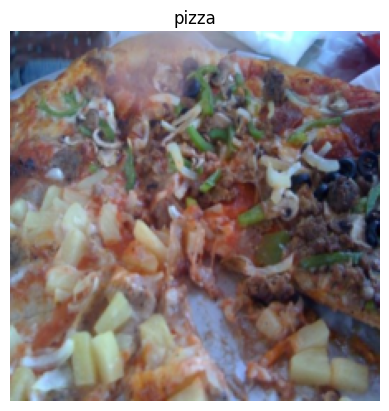

In [12]:
# Use plt.imshow to display the image. Permute the dimensions for correct visualization.
plt.imshow(image.permute(1, 2, 0))

# Set the title of the plot as the corresponding class name
plt.title(class_names[label])

# Turn off axis labels for better visualization
plt.axis(False)

# Show the plot
plt.show()

In [13]:
# Calculate N (number of patches)
number_of_patches = int((height * width) / patch_size**2)
print(f"Number of patches (N) with image height (H={height}), width (W={width}) and patch size (P={patch_size}): {number_of_patches}")

Number of patches (N) with image height (H=224), width (W=224) and patch size (P=16): 196


In [14]:
# Input shape (this is the size of a single image)
embedding_layer_input_shape = (height, width, color_channels)

# Output shape
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 2D image flattened into patches): {embedding_layer_output_shape}")

Input shape (single 2D image): (224, 224, 3)
Output shape (single 2D image flattened into patches): (196, 768)


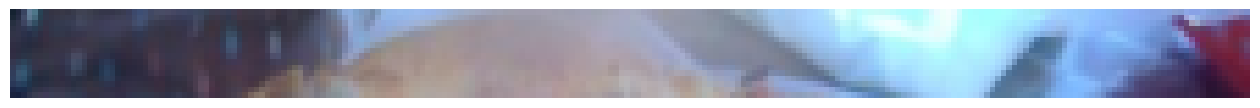

In [15]:
# Change image shape to be compatible with matplotlib (color_channels, height, width) -> (height, width, color_channels)
image_permuted = image.permute(1, 2, 0)

# Index to plot the top row of patched pixels
plt.figure(figsize=(patch_size, patch_size))

# Use plt.imshow to display the top row of patched pixels
plt.imshow(image_permuted[:patch_size, :, :])

# Turn off axis labels for better visualization
plt.axis(False)

# Show the plot
plt.show()

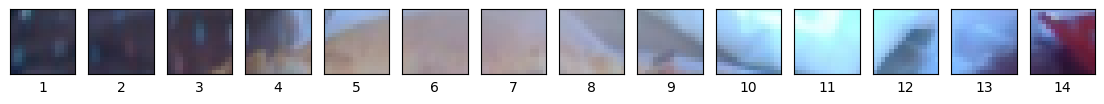

In [16]:
# Create subplots for displaying patches
fig, axs = plt.subplots(
    nrows=1,
    ncols=image_size // patch_size,
    figsize=(image_size // patch_size, image_size // patch_size),
    sharex=True,
    sharey=True
)

# Iterate over patches and display in subplots
for i, patch in enumerate(range(0, image_size, patch_size)):
    # Display the patch in the i-th subplot
    axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :])

    # Set the label for the x-axis
    axs[i].set_xlabel(i + 1)

    # Turn off x and y ticks for better visualization
    axs[i].set_xticks([])
    axs[i].set_yticks([])

# Show the subplots
plt.show()

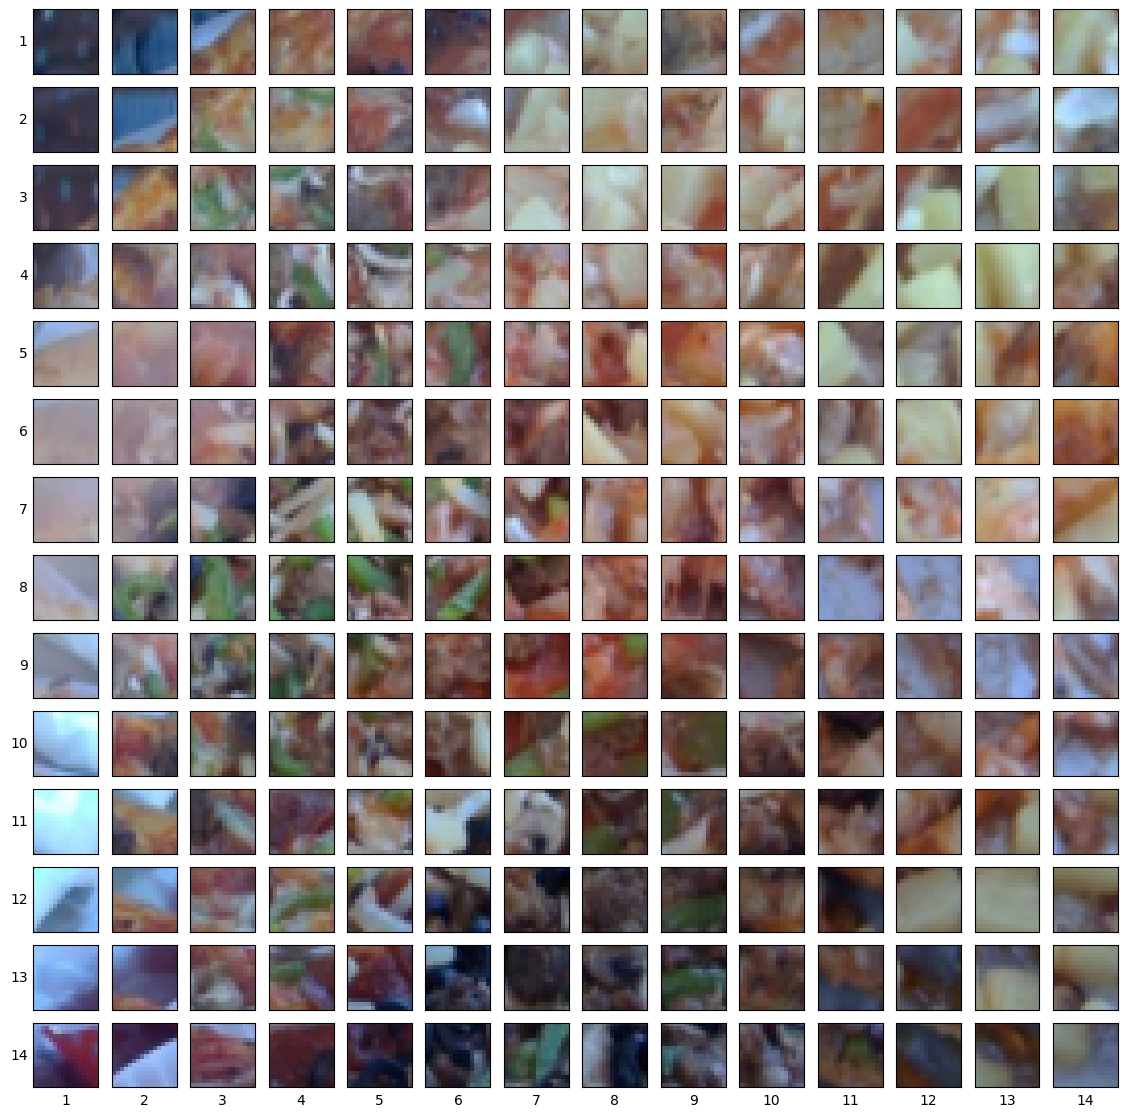

In [17]:
# Create subplots for displaying patches
fig, axs = plt.subplots(
    nrows=image_size // patch_size,
    ncols=image_size // patch_size,
    figsize=(image_size // patch_size, image_size // patch_size),
    sharex=True,
    sharey=True
)

# Iterate over patches and display in subplots
for i, patch_x in enumerate(range(0, image_size, patch_size)):
    for j, patch_y in enumerate(range(0, image_size, patch_size)):
        # Display the patch in the (i, j) subplot
        axs[i, j].imshow(image_permuted[patch_y:patch_y+patch_size, patch_x:patch_x+patch_size, :])

        # Set the y-axis label for the i-th row
        axs[i, j].set_ylabel(i+1, rotation="horizontal", horizontalalignment="right", verticalalignment="center")

        # Set the x-axis label for the j-th column
        axs[i, j].set_xlabel(j+1)

        # Turn off x and y ticks for better visualization
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])

        # Hide labels for outer subplots to avoid overlap
        axs[i, j].label_outer()

# Show the subplots
plt.show()

In [18]:
# Define a 2D convolutional layer
conv2d_layer = nn.Conv2d(
    in_channels=color_channels,      # Number of input channels (e.g., 3 for RGB)
    out_channels=embedding_dim,      # Number of output channels (embedding dimension)
    kernel_size=patch_size,           # Size of the convolutional kernel (patch size)
    stride=patch_size,               # Stride for the convolution operation
    padding=0                         # Padding for the convolution operation
)

# Apply the convolutional layer to the input image
conv_out = conv2d_layer(image.unsqueeze(0))  # Unsqueeze to add a batch dimension
conv_out.shape  # Display the shape of the output tensor

torch.Size([1, 768, 14, 14])

### Visualizing Randomly Selected Channels from Convolutional Layer Output

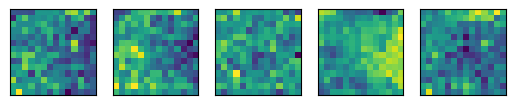

In [19]:
import random
import matplotlib.pyplot as plt

# Set the number of channels to visualize
k = 5

# Randomly sample k indices from the embedding dimension
random_idx = random.sample(range(embedding_dim), k=k)

# Create subplots for visualizing selected channels
fig, ax = plt.subplots(nrows=1, ncols=k)

# Iterate over random indices and visualize corresponding channels
for i, idx in enumerate(random_idx):
    # Display the output of the selected channel
    ax[i].imshow(conv_out[:, idx, :, :].squeeze().detach().numpy())

    # Turn off x and y ticks for better visualization
    ax[i].set_xticks([])
    ax[i].set_yticks([])

In [20]:
# Create flatten layer
flatten_layer = nn.Flatten(start_dim=2, # flatten feature_map_height (dimension 2)
                     end_dim=3) # flatten feature_map_width (dimension 3)

In [21]:
print(f"Original image shape: {image.shape}")

image_out_of_conv = conv2d_layer(image.unsqueeze(0))
print(f"Image feature map shape: {image_out_of_conv.shape}")

image_out_of_conv_flattened = flatten_layer(image_out_of_conv)
print(f"Flattened image feature map shape: {image_out_of_conv_flattened.shape}")

Original image shape: torch.Size([3, 224, 224])
Image feature map shape: torch.Size([1, 768, 14, 14])
Flattened image feature map shape: torch.Size([1, 768, 196])


In [22]:
# Get flattened image patch embeddings in right shape
image_out_of_conv_flattened_reshaped = image_out_of_conv_flattened.permute(0, 2, 1)
print(f"Patch embedding sequence shape: {image_out_of_conv_flattened_reshaped.shape}")

Patch embedding sequence shape: torch.Size([1, 196, 768])


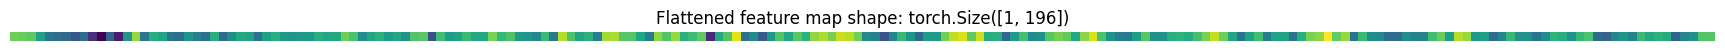

In [23]:
# Get a single flattened feature map
single_flattened_feature_map = image_out_of_conv_flattened_reshaped[:, :, 0]

# Plot the flattened feature map visually
plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False);

## Building the Model

### Patch Embedding Class

This module is typically used as the initial stage of vision transformer models, converting image patches into a sequence of embedded vectors.

In [24]:
class PatchEmbedding(nn.Module):
    """
    Patch Embedding Module

    This module converts an input image into a sequence of embedded patches.

    Args:
        in_channels (int): Number of input channels (default: color_channels).
        patch_size (int): Size of the patches (default: patch_size).
        embedding_dim (int): Dimensionality of the embedded patches (default: embedding_dim).
    """
    def __init__(self, in_channels=color_channels, patch_size=patch_size, embedding_dim=embedding_dim):
        super().__init__()

        # Convolutional layer to extract patches
        self.patcher = nn.Conv2d(
            in_channels=in_channels,
            out_channels=embedding_dim,
            kernel_size=patch_size,
            stride=patch_size,
            padding=0
        )

        # Flatten spatial dimensions of patches
        self.flatten = nn.Flatten(start_dim=2, end_dim=3)

    def forward(self, x):
        """
        Forward pass of the PatchEmbedding module.

        Args:
            x (torch.Tensor): Input tensor representing an image.

        Returns:
            torch.Tensor: Flattened and permuted output tensor.
        """
        # Pass input through the patcher (convolutional layer) and flatten
        out = self.flatten(self.patcher(x))

        # Permute dimensions to have the sequence dimension in the middle
        return out.permute(0, 2, 1)

In [25]:
set_seeds()

# Create an instance of patch embedding layer
patchify = PatchEmbedding(in_channels = color_channels, patch_size = patch_size, embedding_dim = embedding_dim)

# Pass a single image through
print(f"Input image shape: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0))
print(f"Output patch embedding shape: {patch_embedded_image.shape}")

Input image shape: torch.Size([1, 3, 224, 224])
Output patch embedding shape: torch.Size([1, 196, 768])


In [26]:
# Create random input sizes
random_input_image = (1, color_channels, height, width)

summary(PatchEmbedding(), input_size=random_input_image,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20, row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
PatchEmbedding (PatchEmbedding)          [1, 3, 224, 224]     [1, 196, 768]        --                   True
├─Conv2d (patcher)                       [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
├─Flatten (flatten)                      [1, 768, 14, 14]     [1, 768, 196]        --                   --
Total params: 590,592
Trainable params: 590,592
Non-trainable params: 0
Total mult-adds (M): 115.76
Input size (MB): 0.60
Forward/backward pass size (MB): 1.20
Params size (MB): 2.36
Estimated Total Size (MB): 4.17

### Class Embedding Module

The `ClassEmbedding` class defines a module that introduces a learnable class token. This class token is concatenated to the input sequence.

In [27]:
class ClassEmbedding(nn.Module):
    """
    Class Embedding Module

    This module introduces a learnable class token that is concatenated to the input sequence.

    Args:
        embedding_dim (int): Dimensionality of the input and class tokens (default: embedding_dim).
    """
    def __init__(self, embedding_dim=embedding_dim):
        super().__init__()

        # Learnable class token parameter
        self.class_token = nn.Parameter(torch.randn(1, 1, embedding_dim), requires_grad=True)

    def forward(self, x):
        """
        Forward pass of the ClassEmbedding module.

        Args:
            x (torch.Tensor): Input sequence tensor.

        Returns:
            torch.Tensor: Concatenated tensor with the class token.
        """
        # Concatenate the class token with the input sequence along dimension 0
        return torch.cat((self.class_token.expand(x.shape[0], -1, -1), x), dim=1)

In [28]:
class_embedding = ClassEmbedding(embedding_dim = embedding_dim)
patch_and_class_embedding = class_embedding(patch_embedded_image)
print(f"Patch and Class embeddding shape: {patch_and_class_embedding.shape}")

Patch and Class embeddding shape: torch.Size([1, 197, 768])


### Positional Embedding Module

The `PositionalEmbedding` class defines a module that introduces positional embeddings to be added to the input sequence.

In [29]:
class PositionalEmbedding(nn.Module):
    """
    Positional Embedding Module

    This module introduces positional embeddings to be added to the input sequence.

    Args:
        embedding_dim (int): Dimensionality of the positional embeddings (default: embedding_dim).
        max_len (int): Maximum length of the input sequence (default: 5000).
    """
    def __init__(self, embedding_dim=embedding_dim, max_len=5000):
        super(PositionalEmbedding, self).__init__()

        # Create positional embeddings using sine and cosine functions
        pe = torch.zeros(max_len, embedding_dim)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embedding_dim, 2).float() * (-math.log(10000.0) / embedding_dim))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)

        # Register the positional embeddings as a buffer
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Forward pass of the PositionalEmbedding module.

        Args:
            x (torch.Tensor): Input sequence tensor.

        Returns:
            torch.Tensor: Input sequence tensor with added positional embeddings.
        """
        # Add positional embeddings to the input sequence
        return x + self.pe[:x.size(0), :]

In [30]:
position_embedding = PositionalEmbedding(max_len = number_of_patches + 1)
patch_and_position_embedding = position_embedding(patch_and_class_embedding)
print(f"Position embeddding shape: {patch_and_position_embedding.shape}")

Position embeddding shape: torch.Size([1, 197, 768])


In [31]:
# Number of attention heads in the transformer model
num_heads = 12

# Number of transformer layers in the model
num_layers = 12

# Size of the hidden layer in the MLP (Multi-Layer Perceptron) of the transformer model
mlp_size = 3072

# Dropout rate applied in the transformer model
dropout = 0.1

# Number of training epochs
n_epochs = 10

# Learning rate for the optimizer
learning_rate = 3e-3

# Beta1 parameter for the Adam optimizer
beta1 = 0.9

# Beta2 parameter for the Adam optimizer
beta2 = 0.999

# Weight decay applied during optimization to prevent overfitting
weight_decay = 0.3

### Multihead Self-Attention Block Module

The `MultiheadSelfAttentionBlock` class defines a module representing a single block of a transformer model. This block includes multihead self-attention.

In [32]:
class MultiheadSelfAttentionBlock(nn.Module):
    """
    Multihead Self-Attention Block Module

    This module represents a single block of a transformer model, containing multihead self-attention.

    Args:
        embedding_dim (int): Dimensionality of the input embeddings (default: embedding_dim).
        num_heads (int): Number of attention heads in the multihead attention mechanism (default: num_heads).
        attn_dropout (float): Dropout rate applied to the attention weights (default: 0).
    """
    def __init__(self, embedding_dim=embedding_dim, num_heads=num_heads, attn_dropout=0):
        super().__init__()

        # Layer normalization for input
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        # Multihead Self-Attention mechanism
        self.mha = nn.MultiheadAttention(
            embed_dim=embedding_dim,
            num_heads=num_heads,
            dropout=attn_dropout,
            batch_first=True
        )

    def forward(self, x):
        """
        Forward pass of the MultiheadSelfAttentionBlock module.

        Args:
            x (torch.Tensor): Input tensor representing embeddings.

        Returns:
            torch.Tensor: Output tensor after applying multihead self-attention.
        """
        # Apply layer normalization to the input tensor
        x = self.layer_norm(x)

        # Apply multihead self-attention mechanism
        attn_output, _ = self.mha(query=x, key=x, value=x, need_weights=False)

        return attn_output

In [33]:
# Create an instance of MSABlock
multihead_self_attention_block = MultiheadSelfAttentionBlock(embedding_dim=embedding_dim, num_heads=num_heads)

# Pass patch and position image embedding through MSABlock
patched_image_through_msa_block = multihead_self_attention_block(patch_and_position_embedding)
print(f"Input shape of MSA block: {patch_and_position_embedding.shape}")
print(f"Output shape MSA block: {patched_image_through_msa_block.shape}")

Input shape of MSA block: torch.Size([1, 197, 768])
Output shape MSA block: torch.Size([1, 197, 768])


# MLPBlock Module

This module represents a single block of a transformer model, containing a Multi-Layer Perceptron (MLP).

In [34]:
class MLPBlock(nn.Module):
    """
    MLP Block Module

    This module represents a single block of a transformer model, containing a Multi-Layer Perceptron (MLP).

    Args:
        embedding_dim (int): Dimensionality of the input embeddings (default: embedding_dim).
        mlp_size (int): Size of the hidden layer in the MLP (default: mlp_size).
        dropout (float): Dropout rate applied to the MLP layers (default: dropout).
    """
    def __init__(self, embedding_dim=embedding_dim, mlp_size=mlp_size, dropout=dropout):
        super().__init__()

        # Layer normalization for input
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        # Multi-Layer Perceptron (MLP)
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim, out_features=mlp_size),
            nn.GELU(),  # GELU activation function
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size, out_features=embedding_dim),
            nn.Dropout(p=dropout)
        )

    def forward(self, x):
        """
        Forward pass of the MLPBlock module.

        Args:
            x (torch.Tensor): Input tensor representing embeddings.

        Returns:
            torch.Tensor: Output tensor after applying the MLP.
        """
        # Apply layer normalization to the input tensor
        x = self.layer_norm(x)

        # Apply the Multi-Layer Perceptron (MLP)
        x = self.mlp(x)

        return x

In [35]:
mlp_block = MLPBlock(embedding_dim = embedding_dim, mlp_size = mlp_size, dropout = dropout)

patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)
print(f"Input shape of MLP block: {patched_image_through_msa_block.shape}")
print(f"Output shape MLP block: {patched_image_through_mlp_block.shape}")

Input shape of MLP block: torch.Size([1, 197, 768])
Output shape MLP block: torch.Size([1, 197, 768])


### Transformer Encoder Block Module

The `TransformerEncoderBlock` class defines a module representing a single block of a transformer encoder. This block includes
a Multihead Self-Attention (MSA) block followed by a Multi-Layer Perceptron (MLP) block.

In [36]:
class TransformerEncoderBlock(nn.Module):
    """
    Transformer Encoder Block Module

    This module represents a single block of a transformer encoder. It consists of a Multihead Self-Attention (MSA) block
    followed by a Multi-Layer Perceptron (MLP) block.

    Args:
        embedding_dim (int): Dimensionality of the input embeddings (default: embedding_dim).
        num_heads (int): Number of attention heads in the MSA block (default: num_heads).
        mlp_size (int): Size of the hidden layer in the MLP block (default: mlp_size).
        mlp_dropout (float): Dropout rate applied to the MLP layers (default: dropout).
        attn_dropout (float): Dropout rate applied to the attention weights in the MSA block (default: 0).
    """
    def __init__(self, embedding_dim=embedding_dim, num_heads=num_heads, mlp_size=mlp_size, mlp_dropout=dropout, attn_dropout=0):
        super().__init__()

        # Multihead Self-Attention (MSA) block
        self.msa_block = MultiheadSelfAttentionBlock(embedding_dim=embedding_dim, num_heads=num_heads, attn_dropout=attn_dropout)

        # Multi-Layer Perceptron (MLP) block
        self.mlp_block = MLPBlock(embedding_dim=embedding_dim, mlp_size=mlp_size, dropout=mlp_dropout)

    def forward(self, x):
        """
        Forward pass of the TransformerEncoderBlock module.

        Args:
            x (torch.Tensor): Input tensor representing embeddings.

        Returns:
            torch.Tensor: Output tensor after applying the MSA and MLP blocks.
        """
        # Apply Multihead Self-Attention (MSA) block and add residual connection
        x = self.msa_block(x) + x

        # Apply Multi-Layer Perceptron (MLP) block and add residual connection
        x = self.mlp_block(x) + x

        return x

In [37]:
summary(TransformerEncoderBlock(),
        input_size=(1, number_of_patches + 1, embedding_dim), col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20, row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiheadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (mha)                    --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

### Vision Transformer (ViT) Model

The `ViT` class defines a Vision Transformer (ViT) model for image classification.

In [38]:
class ViT(nn.Module):
    """
    Vision Transformer (ViT) Model

    This class defines a Vision Transformer (ViT) model for image classification.

    Args:
        img_size (int): Size of the input image (default: img_size).
        in_channels (int): Number of input channels (default: color_channels).
        patch_size (int): Size of each image patch (default: patch_size).
        num_transformer_layers (int): Number of transformer encoder layers (default: num_layers).
        embedding_dim (int): Dimensionality of the input embeddings (default: embedding_dim).
        mlp_size (int): Size of the hidden layer in the MLP block (default: mlp_size).
        num_heads (int): Number of attention heads in the transformer model (default: num_heads).
        attn_dropout (float): Dropout rate applied to the attention weights (default: 0).
        mlp_dropout (float): Dropout rate applied to the MLP layers (default: dropout).
        embedding_dropout (float): Dropout rate applied to the input embeddings (default: dropout).
        num_classes (int): Number of output classes for classification (default: 1000).
    """
    def __init__(self,
                 img_size=image_size,
                 in_channels=color_channels,
                 patch_size=patch_size,
                 num_transformer_layers=num_layers,
                 embedding_dim=embedding_dim,
                 mlp_size=mlp_size,
                 num_heads=num_heads,
                 attn_dropout=0,
                 mlp_dropout=dropout,
                 embedding_dropout=dropout,
                 num_classes=1000):
        super().__init__()

        # Check if img_size is divisible by patch_size
        assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image size: {img_size}, patch size: {patch_size}."

        # Calculate the number of patches
        self.num_patches = (img_size * img_size) // patch_size**2

        # Components
        self.patch_embedding = PatchEmbedding(in_channels=in_channels, patch_size=patch_size, embedding_dim=embedding_dim)
        self.class_embedding = ClassEmbedding(embedding_dim=embedding_dim)
        self.position_embedding = PositionalEmbedding(max_len=self.num_patches + 1)
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)

        # Transformer Encoder
        self.transformer_encoder = nn.Sequential(
            *[TransformerEncoderBlock(embedding_dim=embedding_dim, num_heads=num_heads, mlp_size=mlp_size,
                                     mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)]
        )

        # Classifier
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim, out_features=num_classes)
        )

    def forward(self, x):
        """
        Forward pass of the ViT model.

        Args:
            x (torch.Tensor): Input tensor representing images.

        Returns:
            torch.Tensor: Output tensor after classification.
        """
        # Patch Embedding
        x = self.patch_embedding(x)

        # Class Embedding
        x = self.class_embedding(x)

        # Positional Embedding
        x = self.position_embedding(x)

        # Apply Embedding Dropout
        x = self.embedding_dropout(x)

        # Transformer Encoder
        x = self.transformer_encoder(x)

        # Classifier
        x = self.classifier(x[:, 0])

        return x

In [39]:
set_seeds()

random_image_tensor = torch.randn(1, 3, 224, 224)

vit = ViT(num_classes=len(class_names))

vit(random_image_tensor)

tensor([[-0.4546, -0.3521, -0.2891]], grad_fn=<AddmmBackward0>)

In [40]:
summary(model=vit,
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                 Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                               [32, 3, 224, 224]    [32, 3]              --                   True
├─PatchEmbedding (patch_embedding)                      [32, 3, 224, 224]    [32, 196, 768]       --                   True
│    └─Conv2d (patcher)                                 [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
│    └─Flatten (flatten)                                [32, 768, 14, 14]    [32, 768, 196]       --                   --
├─ClassEmbedding (class_embedding)                      [32, 196, 768]       [32, 197, 768]       768                  True
├─PositionalEmbedding (position_embedding)              [32, 197, 768]       [32, 197, 768]       --                   --
├─Dropout (embedding_dropout)                           [32, 197, 768]       [32, 197, 768]       --                   --
├─Sequent

## Tarining

In [41]:
#Create an Adam optimizer for training the ViT model
optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=learning_rate,
                             betas=(beta1, beta2),
                             weight_decay=weight_decay)

# Setup the loss function for multi-class classification
loss_fn = torch.nn.CrossEntropyLoss()

# Set the random seeds for reproducibility
set_seeds()

# Train the ViT model and save the training results to a dictionary
results = train(model=vit,
                train_dataloader=train_dataloader,
                test_dataloader=test_dataloader,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=n_epochs,
                device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.3929 | train_acc: 0.2695 | test_loss: 5.2909 | test_acc: 0.2604
Epoch: 2 | train_loss: 2.4390 | train_acc: 0.2969 | test_loss: 1.2414 | test_acc: 0.2604
Epoch: 3 | train_loss: 1.2114 | train_acc: 0.4492 | test_loss: 2.0328 | test_acc: 0.2604
Epoch: 4 | train_loss: 1.3540 | train_acc: 0.3047 | test_loss: 1.7991 | test_acc: 0.1979
Epoch: 5 | train_loss: 1.1813 | train_acc: 0.2852 | test_loss: 1.2273 | test_acc: 0.2396
Epoch: 6 | train_loss: 1.1056 | train_acc: 0.2695 | test_loss: 1.4523 | test_acc: 0.1979
Epoch: 7 | train_loss: 1.1285 | train_acc: 0.3945 | test_loss: 1.8197 | test_acc: 0.1979
Epoch: 8 | train_loss: 1.1575 | train_acc: 0.2930 | test_loss: 1.3523 | test_acc: 0.2604
Epoch: 9 | train_loss: 1.2910 | train_acc: 0.3047 | test_loss: 1.0220 | test_acc: 0.5417
Epoch: 10 | train_loss: 1.2645 | train_acc: 0.3711 | test_loss: 1.3132 | test_acc: 0.2604


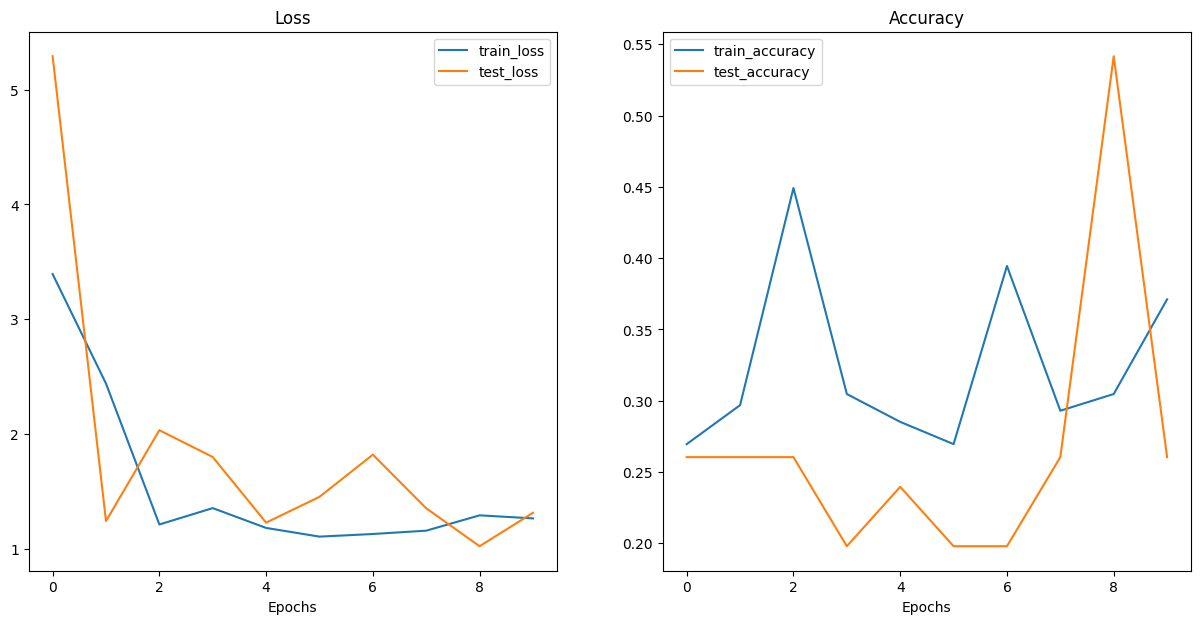

In [42]:
# Plot our ViT model's loss curves
plot_loss_curves(results)

## Second method

### PyTorch Pretrained Vit

In [43]:
# Load pre-trained Vision Transformer (ViT) weights from torchvision
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

# Instantiate a pre-trained ViT model with the specified weights and move it to the target device
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# Display the architecture of the pre-trained ViT model
print(pretrained_vit)

# Freeze the parameters of the pre-trained ViT model to prevent further training
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

# Set random seeds for reproducibility
set_seeds()

# Replace the final classification head of the pre-trained ViT model with a new one suitable for the current task
pretrained_vit.heads = nn.Linear(in_features=embedding_dim, out_features=len(class_names)).to(device)

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [44]:
summary(model=pretrained_vit,
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20, row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 3]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

In [45]:
# Get automatic transforms from pretrained ViT weights
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [46]:
# Create data loaders for training and testing datasets
train_dataloader_pretrained, test_dataloader_pretrained, class_names = create_dataloaders(
    train_path=train_dir,           # Path to the training dataset
    test_path=test_dir,             # Path to the testing dataset
    transform=pretrained_vit_transforms,    # Pretrained Vit Image transformations to apply
    batch_size=batch_size,           # Batch size for training and testing
    num_workers=os.cpu_count()       # Number of parallel workers for data loading
)

# Print the created data loaders and class names
train_dataloader_pretrained, test_dataloader_pretrained, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7afd98205e10>,
 ['pizza', 'steak', 'sushi'])

In [47]:
# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(), lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
set_seeds()
pretrained_vit_results = train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=n_epochs,
                                      device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7663 | train_acc: 0.7188 | test_loss: 0.5435 | test_acc: 0.8769
Epoch: 2 | train_loss: 0.3436 | train_acc: 0.9453 | test_loss: 0.3257 | test_acc: 0.8977
Epoch: 3 | train_loss: 0.2068 | train_acc: 0.9492 | test_loss: 0.2698 | test_acc: 0.9186
Epoch: 4 | train_loss: 0.1557 | train_acc: 0.9609 | test_loss: 0.2414 | test_acc: 0.9186
Epoch: 5 | train_loss: 0.1244 | train_acc: 0.9727 | test_loss: 0.2271 | test_acc: 0.8977
Epoch: 6 | train_loss: 0.1210 | train_acc: 0.9766 | test_loss: 0.2122 | test_acc: 0.9280
Epoch: 7 | train_loss: 0.0933 | train_acc: 0.9766 | test_loss: 0.2342 | test_acc: 0.8883
Epoch: 8 | train_loss: 0.0793 | train_acc: 0.9844 | test_loss: 0.2268 | test_acc: 0.9081
Epoch: 9 | train_loss: 0.1084 | train_acc: 0.9883 | test_loss: 0.2064 | test_acc: 0.9384
Epoch: 10 | train_loss: 0.0646 | train_acc: 0.9922 | test_loss: 0.1795 | test_acc: 0.9176


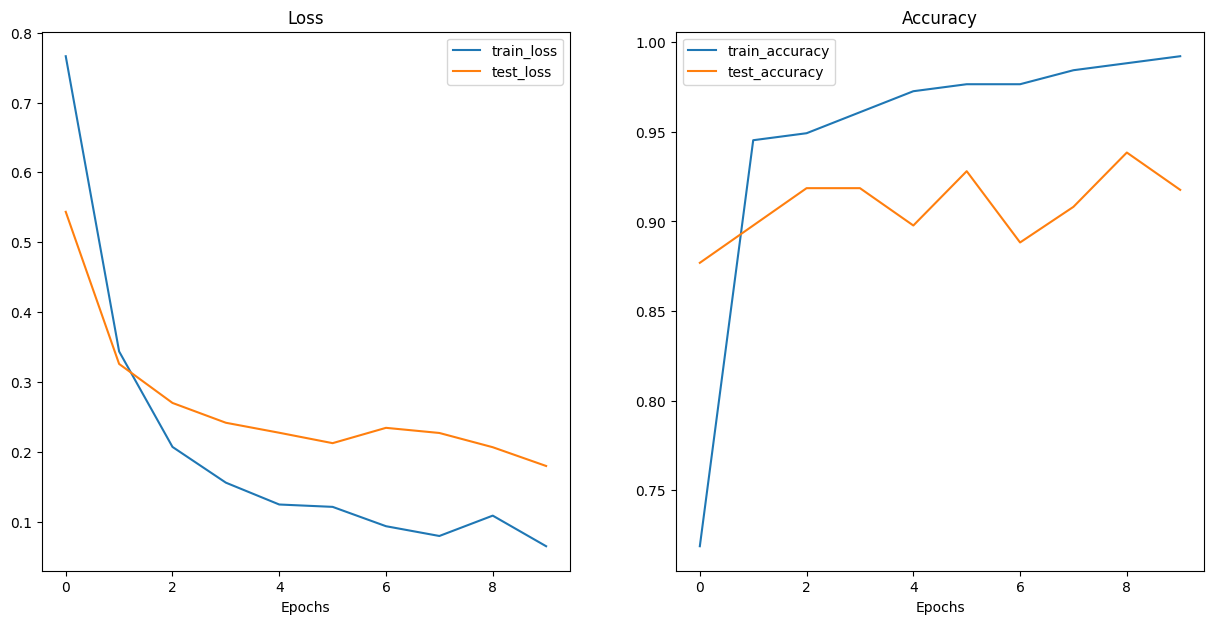

In [48]:
plot_loss_curves(pretrained_vit_results)

### Prediction

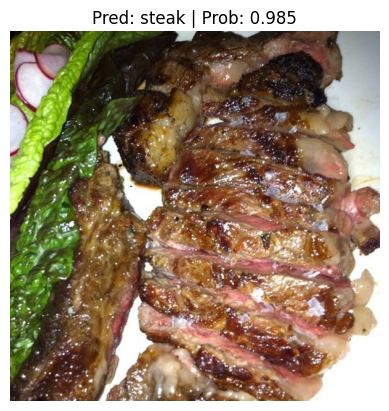

In [52]:
# Setup custom image path
custom_image_path = "/content/data/pizza_steak_sushi/test/steak/1016217.jpg"

# Predict on custom image
pred_and_plot_image(model=pretrained_vit, image_path=custom_image_path, class_names=class_names)